# **Data analysis on projects**

This notebook runs a bunch of data analysis on the projects and saves the analysis to `data/processed/projects`.

In [ ]:
import sys
import subprocess


subprocess.check_call([
    sys.executable, "-m", "pip", "install", "--upgrade",
    "pandas",
    "plotly",
    "wordcloud",
    "matplotlib",
    "numpy",
    "kaleido",
    "pyarrow"
])

# Imports and setup

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import numpy as np
import matplotlib.pyplot as plt  
from pathlib import Path
import json
import plotly.io as pio

df = pd.read_parquet('../data/projects.parquet')
index = {
    "numerical":{},
    "top":{},
    "graphs":{},
}

In [3]:
from pathlib import Path
import plotly.io as pio
import plotly.graph_objects as go

EXPORT_DIR = Path('../data/processed/projects').resolve()
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

DEFAULT_WIDTH = 1100
DEFAULT_HEIGHT = 420

som_wide = go.layout.Template(layout=dict(
    width=DEFAULT_WIDTH,
    margin=dict(l=60, r=30, t=60, b=50),
))
pio.templates['som_wide'] = som_wide
pio.templates.default = 'plotly_white+som_wide'

try:
    pio.renderers.default = 'vscode'
except Exception:
    pass


def register_graph(key: str, name: str, description: str, image_file: str):
    index['graphs'][key] = {
        'name': name,
        'description': description,
        'image_file': Path(image_file).name,
    }


def save_plotly(fig, name: str, description: str, scale: int = 2, width=None, height=None, friendly_name: str = ""):
    filename = f"{name}.png"
    out_path = EXPORT_DIR / filename
    try:
        exp_width = width if width is not None else (fig.layout.width or DEFAULT_WIDTH)
        exp_height = height if height is not None else (fig.layout.height or DEFAULT_HEIGHT)
        fig.write_image(str(out_path), scale=scale, width=exp_width, height=exp_height)
        register_graph(name, friendly_name, description, filename)
    except Exception as e:
        print(f'Failed to save Plotly figure {name}: {e}')


def save_matplotlib_current(name: str, description: str, dpi: int = 150, friendly_name: str = ""):
    filename = f"{name}.png"
    out_path = EXPORT_DIR / filename
    try:
        plt.gcf().savefig(out_path, bbox_inches='tight', dpi=dpi, facecolor='white')
        register_graph(name, friendly_name, description, filename)
    except Exception as e:
        print(f'Failed to save Matplotlib figure {name}: {e}')


def save_to_index(key: str, name: str, description: str, data, type="numerical"):
    if isinstance(data, pd.DataFrame):
        records = data.to_dict(orient='records')
        indexed = {i: rec for i, rec in enumerate(records)}
        index[type][key] = {
            'name': name,
            'description': description,
            'data': indexed,
        }
    else:
        index[type][key] = {
            'name': name,
            'description': description,
            'data': data,
        }

# Numerical data
Some quick summary stats for projects.

In [4]:
import numpy as np

cols = df.columns.str.lower()
time_col = 'total_seconds_coded'

if 'devlogs_count' not in cols:
    df['devlogs_count'] = np.nan

sec = pd.to_numeric(df[time_col], errors='coerce').fillna(0)
hrs = sec / 3600.0

avg_devlogs = pd.to_numeric(df['devlogs_count'], errors='coerce').mean()
avg_hours = hrs.mean()
project_count = len(df)

print(f"Projects: {project_count}")
print(f"Average devlogs per project: {avg_devlogs:.2f}")
print(f"Average coding time (hours): {avg_hours:.2f}")

save_to_index('project_count', 'Total projects', 'Total number of projects', int(project_count), type='numerical')
save_to_index('avg_devlogs_per_project', 'Avg devlogs per project', 'Average of devlogs_count across projects', float(avg_devlogs), type='numerical')
save_to_index('avg_hours_per_project', 'Avg coding hours per project', 'Average coding time in hours across projects', float(avg_hours), type='numerical')

Projects: 8598
Average devlogs per project: 3.27
Average coding time (hours): 9.78


### Devlog-Hour ratio
Compute number of devlogs per 40 hours and per hour.

In [5]:
sec = pd.to_numeric(df[time_col], errors='coerce').fillna(0)
hrs = sec / 3600.0

devlogs = pd.to_numeric(df['devlogs_count'], errors='coerce')

ratio_per_hour = (devlogs / hrs.replace(0, np.nan))
ratio_per_hour = ratio_per_hour.replace([np.inf, -np.inf], np.nan)
ratio_10h = ratio_per_hour * 10

mean_ratio_per_hour = ratio_per_hour.mean(skipna=True)
mean_ratio_10h = ratio_10h.mean(skipna=True)

print(f"Average devlogs per hour: {mean_ratio_per_hour:.4f}")
print(f"Average devlogs per 10 hours: {mean_ratio_10h:.2f}")

save_to_index('devlogs_per_hour_avg', 'Avg devlogs per hour', 'Average devlogs produced per coding hour across projects', float(mean_ratio_per_hour), type='numerical')
save_to_index('devlogs_per_10h_avg', 'Avg devlogs per 10 hours', 'Average number of devlogs per 10 coding hours across projects', float(mean_ratio_10h), type='numerical')

Average devlogs per hour: 0.8486
Average devlogs per 10 hours: 8.49


# Graphical Data
Visual summaries for projects.

## No of Projects created per Date
This chart shows number of projects created on each date.

In [6]:
ts = None
for cand in ['created_date', 'created_at']:
    if cand in df.columns:
        ts = pd.to_datetime(df[cand], errors='coerce')
        break

if ts is None:
    print('No created_at/created_date column available for date aggregation')
else:
    counts = (
        pd.DataFrame({'date': ts.dt.date})
          .dropna(subset=['date'])
          .groupby('date')
          .size()
          .reset_index(name='project_count')
          .sort_values('date')
    )

    counts['date'] = pd.to_datetime(counts['date'])
    counts['rolling_7d'] = counts['project_count'].rolling(7, min_periods=1).mean()

    fig = px.bar(
        counts, x='date', y='project_count',
        title='Projects per Day',
        labels={'date': 'Date', 'project_count': 'Projects'},
        color_discrete_sequence=['#636EFA']
    )
    fig.add_scatter(x=counts['date'], y=counts['rolling_7d'], name='7-day average', mode='lines', line=dict(color='#EF553B', width=2))

    fig.update_traces(hovertemplate='Date=%{x|%Y-%m-%d}<br>Projects=%{y}')
    fig.update_layout(
        hovermode='x unified', bargap=0.15,
        height=max(DEFAULT_HEIGHT, 420),
        xaxis=dict(title='Date', tickformat='%b %Y', showgrid=False, rangeslider=dict(visible=True)),
        yaxis=dict(title='Projects', showgrid=True, gridcolor='rgba(0,0,0,0.08)')
    )
    fig.show()

    save_plotly(fig, name='projects_per_day', description='Number of projects per day with 7-day rolling mean', friendly_name='Projects per Day')

## Growth of projects over time
Cumulative total of projects across dates.

In [7]:
ts = None
for cand in ['created_date', 'created_at']:
    if cand in df.columns:
        ts = pd.to_datetime(df[cand], errors='coerce')
        break

if ts is None:
    print('No created_at/created_date column available for cumulative chart')
else:
    series = (
        pd.DataFrame({'date': ts.dt.date})
          .dropna()
          .groupby('date')
          .size()
          .reset_index(name='count')
          .sort_values('date')
    )
    series['date'] = pd.to_datetime(series['date'])
    series['cumulative'] = series['count'].cumsum()

    fig = px.area(series, x='date', y='cumulative',
                  title='Cumulative Projects',
                  labels={'date': 'Date', 'cumulative': 'Total Projects'},
                  color_discrete_sequence=['#19A974'])
    fig.update_layout(height=max(DEFAULT_HEIGHT, 420))
    fig.show()
    save_plotly(fig, name='cumulative_projects', description='Cumulative total of projects over time', friendly_name='Cumulative Projects')

## Top projects by time and devlogs
Horizontal bars for top N by total coding time and by devlogs_count.

In [8]:
TOP_N = 15

title_col = None
for cand in ['title', 'project_title', 'name', 'display_name']:
    if cand in df.columns:
        title_col = cand
        break

_sec = pd.to_numeric(df[time_col], errors='coerce').fillna(0)
_dev = pd.to_numeric(df['devlogs_count'], errors='coerce')

_time_df = df.copy()
_time_df['hours'] = _sec / 3600.0
if title_col:
    _time_df['label'] = _time_df[title_col].astype(
        'object').fillna('(untitled)').astype(str).str.slice(0, 40)
else:
    _time_df['label'] = _time_df.get(
        'id', pd.Series(range(len(_time_df)))).astype(str)

by_hours = _time_df.sort_values('hours', ascending=False).head(TOP_N)

_dev_df = df.copy()
_dev_df['devlogs_count_num'] = _dev
if title_col:
    _dev_df['label'] = _dev_df[title_col].astype('object').fillna(
        '(untitled)').astype(str).str.slice(0, 40)
else:
    _dev_df['label'] = _dev_df.get(
        'id', pd.Series(range(len(_dev_df)))).astype(str)
by_devlogs = _dev_df.sort_values(
    'devlogs_count_num', ascending=False).head(TOP_N)

height = max(len(by_hours), len(by_devlogs)) * 44 + 240

fig = make_subplots(rows=1, cols=2, column_widths=[0.5, 0.5],
                    subplot_titles=('Top Projects by Coding Time (hours)',
                                    'Top Projects by Devlogs Count'))

fig.add_trace(go.Bar(x=by_hours['hours'][::-1], y=by_hours['label'][::-1],
                     orientation='h', marker_color='#636EFA',
                     hovertemplate='%{y}<br>Total=%{x:.2f} h'), row=1, col=1)

fig.add_trace(go.Bar(x=by_devlogs['devlogs_count_num'][::-1], y=by_devlogs['label'][::-1],
                     orientation='h', marker_color='#EF553B',
                     hovertemplate='%{y}<br>Devlogs=%{x:.0f}'), row=1, col=2)

fig.update_layout(height=max(DEFAULT_HEIGHT + (len(by_hours)*18), height),
                  margin=dict(l=220, r=30, t=80, b=40), showlegend=False, bargap=0.25)
fig.update_xaxes(title_text='Hours', row=1, col=1)
fig.update_xaxes(title_text='Devlogs', row=1, col=2)
fig.update_yaxes(title_text='Project', row=1, col=1,
                 automargin=True, tickfont=dict(size=11))
fig.update_yaxes(title_text='Project', row=1, col=2,
                 automargin=True, tickfont=dict(size=11))
fig.show()

save_plotly(fig, name='top_projects_time_and_devlogs',
            description='Two horizontal bar charts: top projects by total coding time and by devlogs_count', friendly_name='Top projects by time and devlogs')

TOP_N = 5

hours_table = by_hours[[c for c in ['id']
                        if c in by_hours.columns] + ['label', 'hours']].copy()
hours_table['hours'] = hours_table['hours'].round(2)
if 'id' in by_hours.columns:
    hours_table['project_link'] = hours_table['id'].apply(
        lambda x: f"https://summer.hackclub.com/projects/{int(x)}")
save_to_index('top_projects_by_hours', 'Top projects by coding time',
              'Top projects ranked by total coding hours', hours_table.head(TOP_N), type='top')

devlogs_table = by_devlogs[[c for c in [
    'id'] if c in by_devlogs.columns] + ['label', 'devlogs_count_num']].copy()
devlogs_table.rename(
    columns={'devlogs_count_num': 'devlogs_count'}, inplace=True)
if 'id' in by_devlogs.columns:
    devlogs_table['project_link'] = devlogs_table['id'].apply(
        lambda x: f"https://summer.hackclub.com/projects/{int(x)}")
save_to_index('top_projects_by_devlogs', 'Top projects by devlogs count',
              'Top projects ranked by devlogs_count', devlogs_table.head(TOP_N), type='top')

# Wordcloud

Its a worldcloud...yep

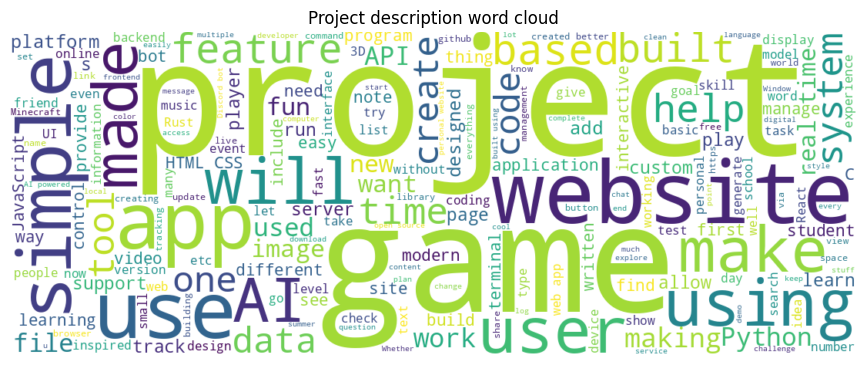

In [22]:
if 'description' not in df.columns:
    print('No description column available for word cloud')
else:
    texts = df['description'].dropna().astype(str)
    if texts.empty:
        print('No description text to build word cloud')
    else:
        text = " ".join(texts)

        wc = WordCloud(width=DEFAULT_WIDTH, height=DEFAULT_HEIGHT, background_color='white', colormap='viridis', max_words=200).generate(text)
        plt.figure(figsize=(DEFAULT_WIDTH/100, DEFAULT_HEIGHT/100))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title('Project description word cloud')
        plt.show()

        save_matplotlib_current('project_description_wordcloud', 'Word cloud of project descriptions', dpi=150, friendly_name='Project description word cloud')
        plt.close()

## When are projects created?
Heatmap of project counts by day of week and hour (UTC).

In [9]:
ts = None
for cand in ['created_at', 'created_date']:
    if cand in df.columns:
        ts = pd.to_datetime(df[cand], errors='coerce', utc=True)
        break

if ts is None:
    print('No created_at/created_date for heatmap')
else:
    dow = ts.dt.day_name()
    hour = ts.dt.hour

    _counts = (
        pd.DataFrame({'dow': dow, 'hour': hour})
          .dropna()
          .assign(hour=lambda d: pd.to_numeric(d['hour'], errors='coerce').astype('Int64'))
          .dropna()
          .assign(hour=lambda d: d['hour'].astype(int).clip(0, 23))
          .groupby(['dow', 'hour'], observed=False)
          .size()
          .reset_index(name='count')
    )

    dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    hour_order = list(range(24))

    pivot = (
        _counts.pivot_table(index='dow', columns='hour', values='count', fill_value=0)
               .reindex(index=dow_order, columns=hour_order, fill_value=0)
    )

    fig = px.imshow(pivot, labels=dict(x='Hour (UTC)', y='Day of Week', color='Projects'),
                    color_continuous_scale='Blues', aspect='auto',
                    title='Projects by Day of Week and Hour (UTC)')
    fig.update_layout(height=max(DEFAULT_HEIGHT + 40, 460), margin=dict(l=60, r=30, t=60, b=40))
    fig.show()

    save_plotly(fig, name='projects_heatmap_dow_hour', description='Heatmap of project creation by day of week and hour (UTC)', friendly_name='Projects heatmap (DOW vs Hour)')

## Project map (island)
Scatter plot of project pins using x and y coordinates.

In [10]:
x_col, y_col = None, None
for cand in ['x', 'x_coord', 'x_coordinate']:
    if cand in df.columns:
        x_col = cand
        break
for cand in ['y', 'y_coord', 'y_coordinate']:
    if cand in df.columns:
        y_col = cand
        break

if x_col is None or y_col is None:
    print('No x/y coordinate columns found for map')
else:
    _map = df.copy()
    _map['x_num'] = pd.to_numeric(_map[x_col], errors='coerce')
    _map['y_num'] = pd.to_numeric(_map[y_col], errors='coerce')
    _map = _map.dropna(subset=['x_num', 'y_num'])

    title_col = None
    for cand in ['title', 'project_title', 'name', 'display_name']:
        if cand in _map.columns:
            title_col = cand
            break

    fig = px.scatter(_map, x='x_num', y='y_num',
                     title='Project Pins on Island Map',
                     labels={'x_num': 'X', 'y_num': 'Y'},
                     hover_data={title_col: True} if title_col else None)
    fig.update_yaxes(autorange='reversed')  # y-down if background image aligns that way
    fig.update_layout(height=max(DEFAULT_HEIGHT, 500))
    fig.show()
    save_plotly(fig, name='project_map_scatter', description='Scatter plot of project pins using x/y map coordinates', friendly_name='Projects Map (scatter)')

## Category Distribution
Donut chart showing share of projects by category.

In [11]:
K = 12

if 'category' not in df.columns:
    print('No category column for distribution chart')
else:
    vc = (df['category'].astype(str)
                      .str.strip()
                      .replace({'': pd.NA, 'None': pd.NA, 'nan': pd.NA})
                      .dropna()
                      .value_counts())
    if len(vc) <= K:
        labels = vc.index.tolist()
        values = vc.values.tolist()
    else:
        top = vc.head(K)
        others = vc.iloc[K:].sum()
        labels = top.index.tolist() + ['Other']
        values = top.values.tolist() + [others]

    fig = go.Figure(go.Pie(labels=labels, values=values, hole=0.5,
                            textinfo='label+percent',
                            hovertemplate='%{label}: %{value} projects (%{percent})'))
    fig.update_layout(title_text='Category Distribution (Projects)',
                      height=max(DEFAULT_HEIGHT, 420), showlegend=False)
    fig.show()

    save_plotly(fig, name='project_category_distribution', description='Donut chart showing share of projects by category (top-k + Other)', friendly_name='Category Distribution (Projects)')

## Time distributions and relationships
- Distribution of coding time (hours)
- Relationship between coding time and votes/ships/devlogs

In [12]:
hrs = pd.to_numeric(df[time_col], errors='coerce').fillna(0) / 3600.0

fig = px.histogram(hrs.dropna(), nbins=40,
                   title='Distribution of Coding Time per Project',
                   labels={'value': 'Hours', 'count': 'Projects'},
                   color_discrete_sequence=['#636EFA'])
fig.update_traces(marker_line_color='white', marker_line_width=0.5)
fig.update_layout(bargap=0.05, height=max(DEFAULT_HEIGHT - 20, 400),
                  xaxis_title='Hours', yaxis_title='Projects')
fig.show()
save_plotly(fig, name='project_time_distribution', description='Histogram of coding time per project', friendly_name='Time Distribution (Projects)')

cand_cols = [c for c in ['votes_count', 'likes_count', 'ships_count', 'devlogs_count'] if c in df.columns]
if cand_cols:
    for col in cand_cols:
        y = pd.to_numeric(df[col], errors='coerce')
        plot_df = pd.DataFrame({'hours': hrs, col: y}).dropna()
        if plot_df.empty:
            continue
        try:
            fig = px.scatter(plot_df, x='hours', y=col, trendline='ols',
                             title=f'{col} vs Coding Time',
                             labels={'hours': 'Hours', col: col.replace('_', ' ').title()})
        except Exception:
            fig = px.scatter(plot_df, x='hours', y=col,
                             title=f'{col} vs Coding Time',
                             labels={'hours': 'Hours', col: col.replace('_', ' ').title()})
        fig.update_layout(height=max(DEFAULT_HEIGHT, 420))
        fig.show()
        save_plotly(fig, name=f'{col}_vs_hours', description=f'Scatter of {col} versus coding time (hours)', friendly_name=f"{col.replace('_',' ').title()} vs Hours")

# Save all the info to an index for web stuff

In [ ]:
index_path = EXPORT_DIR / 'index.json'
with open(index_path, 'w', encoding='utf-8') as f:
    json.dump(index, f, indent=4)
print(f'Wrote index to {index_path}')